### Cell A — Setup & Config (paths, knobs, seeding)

clip_len=32 / stride=2: good temporal coverage without blowing VRAM.

r3d18_k400: strong pretrained baseline; we’ll fine-tune.

staged unfreeze: learn head → then gently unfreeze layer4 to reduce overfitting/instability.

AMP: speedup + memory savings; using the correct torch.amp.autocast('cuda') API.

In [3]:
# === Cell A — Config / Paths / Globals ===
from pathlib import Path
import yaml, json, os
from datetime import datetime

# --- project root & src on sys.path (if you need your modules) ---
root = Path("..").resolve()                 # notebook sits at repo root
CONFIG_YAML = root / "configs" / "wlasl100.yaml"

# --- load your existing yaml (optional; we still set overrides below) ---
CFG = yaml.safe_load(open(CONFIG_YAML, "r")) if CONFIG_YAML.exists() else {}

# --- core run configuration (overrides are explicit here) ---
CONFIG = {
    # data
    "manifest": "data/wlasl_preprocessed/manifest_nslt100.csv",
    "clip_len": 32,                # 16 works, 32 helps temporal cues
    "frame_stride": 2,
    "batch_size": 8,
    "num_workers": 4,
    "use_weighted_sampler": True,  # class rebalancing
    "normalize": "kinetics",       # ['kinetics','none']

    # model & training
    "backbone": "r3d18_k400",      # ['r3d18_k400','c3dlite_gn']
    "dropout": 0.2,
    "label_smoothing": 0.0,
    "epochs": 25,
    "warmup_epochs": 2,
    "lr_head_stage1": 1e-3,        # head-only stage
    "lr_back_stage1": 0.0,
    "lr_head_stage2": 1e-4,        # unfreeze last block
    "lr_back_stage2": 1e-5,
    "weight_decay": 1e-5,
    "cosine_eta_min": 1e-5,
    "amp": True,
    "compile": True,
    "freeze_backbone": True,
    "unfreeze_at_epoch": 5,
    "unfreeze_scope": "layer4",

    # paths
    "checkpoints_dir": "checkpoints",
    "runs_dir": "runs",

    # reproducibility
    "seed": 42,
}

# derived paths
MANIFEST = root / CONFIG["manifest"]
CKPT_DIR = root / CONFIG["checkpoints_dir"]
RUNS_DIR = root / CONFIG["runs_dir"]
CKPT_DIR.mkdir(parents=True, exist_ok=True)
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# run tag (deterministic name for files)
run_tag = f"wlasl100_{CONFIG['backbone']}_T{CONFIG['clip_len']}_B{CONFIG['batch_size']}_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}"

# persist run config for traceability
with open(RUNS_DIR / f"{run_tag}.config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("root:", root)
print("manifest:", MANIFEST)
print("checkpoints:", CKPT_DIR)
print("runs:", RUNS_DIR)
print("run_tag:", run_tag)


root: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL
manifest: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt100.csv
checkpoints: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints
runs: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs
run_tag: wlasl100_r3d18_k400_T32_B8_20251109T174731Z


### Cell B — Data Loader (self-contained, robust)
A tiny inline Dataset avoids surprises from older src.data.* code.

We normalize like Kinetics (what r3d_18 expects).

We skip missing/corrupt paths up front

In [4]:
# === Cell B — Data loader (reads manifest) ===
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import random

# ---- seed everything ----
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
seed_everything(CONFIG["seed"])

# ---- tiny, robust video reader helpers (prefer decord if installed) ----
USE_DECORD = False
try:
    import decord
    decord.bridge.set_bridge('torch')
    USE_DECORD = True
except Exception:
    from torchvision.io import read_video


def read_clip(path, clip_len, stride, size=(112,112)):
    """
    Returns a Tensor [T, C, H, W] in float32 [0,1].
    - Samples T=clip_len frames with step=stride (loop/pad if short).
    - Resizes to 112x112 for r3d_18 default.
    """
    import torch.nn.functional as F
    import torchvision.transforms.functional as TF

    if USE_DECORD:
        vr = decord.VideoReader(path)
        total = len(vr)
        idxs = np.arange(0, clip_len*stride, stride)
        idxs = idxs % max(1, total)
        frames = vr.get_batch(idxs).byte()        # [T, H, W, C], uint8
        frames = frames.permute(0,3,1,2).float() / 255.0
    else:
        v, _, _ = read_video(path, pts_unit="sec")  # [T, H, W, C], uint8
        v = v.permute(0,3,1,2).float() / 255.0
        total = v.shape[0]
        if total == 0:
            # fallback: create blank clip if video corrupt/missing
            frames = torch.zeros(clip_len, 3, size[0], size[1])
            return frames
        idxs = np.arange(0, clip_len*stride, stride) % total
        frames = v[idxs]

    # resize frames to (112,112)
    frames = torch.stack([TF.resize(f, size, antialias=True) for f in frames])  # list of [C,H,W]
    return frames  # [T,C,H,W]


def kinetics_normalize(x):
    # x [T,C,H,W]
    mean = torch.tensor((0.432,0.394,0.376), dtype=x.dtype, device=x.device)[None,:,None,None]
    std  = torch.tensor((0.228,0.221,0.223), dtype=x.dtype, device=x.device)[None,:,None,None]
    return (x - mean) / std


class WLASLFromManifest(Dataset):
    """
    Minimal dataset that reads your Kaggle manifest:
      columns: video_path|path, gloss, label, split
    Returns: X [T,C,H,W], y (int), meta (dict)
    """
    def __init__(self, df, clip_len=32, stride=2, train=False, normalize="kinetics"):
        self.df = df.reset_index(drop=True).copy()
        self.clip_len = clip_len
        self.stride = stride
        self.train = train
        self.normalize = normalize

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = row.get("path", row.get("video_path"))
        x = read_clip(p, self.clip_len, self.stride, size=(112,112))     # [T,C,H,W]
        if self.normalize == "kinetics":
            x = kinetics_normalize(x)
        y = int(row["label"])
        return x, torch.tensor(y, dtype=torch.long), {"path": p}


# ---- read manifest & harmonize paths ----
m = pd.read_csv(MANIFEST)
if "video_path" in m.columns and "path" not in m.columns:
    m = m.rename(columns={"video_path": "path"})
m["path"]  = m["path"].apply(lambda p: str((root / p).resolve()))
m["label"] = m["label"].astype(int)

# ---- drop missing to avoid reader errors ----
exists_mask = m["path"].map(lambda p: Path(p).exists())
missing = (~exists_mask).sum()
if missing:
    print(f"[Data] Skipping {missing} missing/corrupt videos.")
    m = m[exists_mask].reset_index(drop=True)

# ---- splits ----
train_df = m[m.split=="train"].reset_index(drop=True)
val_df   = m[m.split=="val"].reset_index(drop=True)
test_df  = m[m.split=="test"].reset_index(drop=True)
num_classes = m["label"].nunique()

# ---- datasets ----
train_ds = WLASLFromManifest(train_df, clip_len=CONFIG["clip_len"], stride=CONFIG["frame_stride"],
                             train=True, normalize=CONFIG["normalize"])
val_ds   = WLASLFromManifest(val_df,   clip_len=CONFIG["clip_len"], stride=CONFIG["frame_stride"],
                             train=False, normalize=CONFIG["normalize"])
test_ds  = WLASLFromManifest(test_df,  clip_len=CONFIG["clip_len"], stride=CONFIG["frame_stride"],
                             train=False, normalize=CONFIG["normalize"])

# ---- loaders ----
bs, nw = CONFIG["batch_size"], CONFIG["num_workers"]
if CONFIG["use_weighted_sampler"]:
    counts  = train_df["label"].value_counts().to_dict()
    weights = train_df["label"].map(lambda y: 1.0 / counts[y]).values.astype("float32")
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=bs, sampler=sampler, num_workers=nw, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)

print(f"Splits | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)} | classes={num_classes}")

# quick sanity batch
xb, yb, mb = next(iter(train_loader))
print("train batch:", xb.shape, yb[:8].tolist())


Splits | train=748 val=165 test=100 | classes=100
train batch: torch.Size([8, 32, 3, 112, 112]) [49, 25, 58, 43, 16, 56, 28, 40]


### Cell C — Training (staged unfreeze, AMP fixed)

In [12]:
# === Cell C — Training (pretrained r3d18, staged unfreeze) ===
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---- model ----
from torchvision.models.video import r3d_18, R3D_18_Weights

if CONFIG["backbone"] == "r3d18_k400":
    weights = R3D_18_Weights.KINETICS400_V1
    model = r3d_18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # match 100 classes
else:
    class C3DliteGN(nn.Module):
        def __init__(self, num_classes=100, drop=0.5):
            super().__init__()
            def gn(c): return nn.GroupNorm(num_groups=8, num_channels=c)
            def block(cin, cout, pool_t=2):
                return nn.Sequential(
                    nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                    gn(cout), nn.ReLU(inplace=True),
                    nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2))
                )
            self.stem = nn.Sequential(nn.Conv3d(3,32,3,padding=1,bias=False), gn(32), nn.ReLU(inplace=True))
            self.b1 = block(32,  64)
            self.b2 = block(64, 128)
            self.b3 = block(128, 256)
            self.b4 = block(256, 256)
            self.head = nn.Sequential(nn.AdaptiveAvgPool3d(1), nn.Flatten(),
                                      nn.Dropout(CONFIG["dropout"]), nn.Linear(256, num_classes))
        def forward(self, x):              # x: [B,T,C,H,W]
            x = x.permute(0,2,1,3,4).contiguous()  # -> [B,C,T,H,W]
            x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
            return self.head(x)

    model = C3DliteGN(num_classes=num_classes, drop=CONFIG["dropout"])

model.to(device)
EXPECTS_BCTHW = (CONFIG["backbone"] == "r3d18_k400")

# ---- freeze helpers ----
def set_frozen(module, frozen=True):
    for p in module.parameters():
        p.requires_grad = not frozen

# Initial freezing (stage 1: head only)
if CONFIG["freeze_backbone"]:
    set_frozen(model, True)                        # freeze all
    if hasattr(model, "fc"):
        set_frozen(model.fc, False)                # train head
    scope = CONFIG["unfreeze_scope"]
    if hasattr(model, scope):
        set_frozen(getattr(model, scope), True)    # keep last block frozen until unfreeze

# ---- criterion / optim / sched / scaler ----
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["label_smoothing"])

# Build param groups by identity (no overlap)
head_params = list(model.fc.parameters()) if hasattr(model, "fc") else []
head_ids = {id(p) for p in head_params}
backbone_params = [p for p in model.parameters() if id(p) not in head_ids]
assert not any(id(p) in head_ids for p in backbone_params), "Param overlap!"

optimizer = optim.AdamW(
    [
        {"params": head_params,     "lr": CONFIG["lr_head_stage1"]},
        {"params": backbone_params, "lr": CONFIG["lr_back_stage1"]},
    ],
    weight_decay=CONFIG["weight_decay"],
)

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=max(1, CONFIG["epochs"] - CONFIG["warmup_epochs"]),
    eta_min=CONFIG["cosine_eta_min"],
)

scaler = GradScaler(enabled=CONFIG["amp"])

# Optional compile (do this once, after groups built)
if CONFIG.get("compile", True) and hasattr(torch, "compile"):
    try:
        model = torch.compile(model)
        print("torch.compile: ON")
    except Exception as e:
        print("torch.compile skipped:", str(e))

# ---- helpers ----
def warmup_lr(optim, epoch, warmup_epochs, base_head, base_back):
    """Linear warmup for both groups during warmup window."""
    if epoch < warmup_epochs:
        s = float(epoch + 1) / max(1, warmup_epochs)
        optim.param_groups[0]["lr"] = base_head * s
        optim.param_groups[1]["lr"] = base_back * s
        return True
    return False

def accuracy_top1(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_one_epoch(loader, train=True):
    model.train(train)
    total_loss = total_acc = total_n = 0
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # ✅ Fix the shape for r3d_18
        if EXPECTS_BCTHW:
            xb = xb.permute(0, 2, 1, 3, 4).contiguous()  # [B,T,C,H,W] -> [B,C,T,H,W]

        if train:
            optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=CONFIG["amp"]):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = yb.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == yb).float().sum().item()

    return total_loss / max(1,total_n), total_acc / max(1,total_n)


# ---- train loop ----
best_val = -1.0
best_path = CKPT_DIR / "best.pt"
last_path = CKPT_DIR / "last.pt"

print(f"Start training for {CONFIG['epochs']} epochs on {device} | run: {run_tag}")

for epoch in range(CONFIG["epochs"]):
    # warmup or cosine step
    warmed = warmup_lr(
        optimizer, epoch, CONFIG["warmup_epochs"],
        CONFIG["lr_head_stage1"], CONFIG["lr_back_stage1"]
    )
    if not warmed:
        scheduler.step()

    # staged unfreeze
    if CONFIG["freeze_backbone"] and epoch == CONFIG["unfreeze_at_epoch"]:
        scope = CONFIG["unfreeze_scope"]
        if hasattr(model, scope):
            print(f"Unfreezing {scope} at epoch {epoch}")
            set_frozen(getattr(model, scope), False)
        # switch to stage-2 LRs
        optimizer.param_groups[0]["lr"] = CONFIG["lr_head_stage2"]
        optimizer.param_groups[1]["lr"] = CONFIG["lr_back_stage2"]

    tr_loss, tr_acc = run_one_epoch(train_loader, train=True)
    va_loss, va_acc = run_one_epoch(val_loader,   train=False)
    print(f"Epoch {epoch+1:03d}/{CONFIG['epochs']} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    # save last + best
    # --- add right before building `state` in Cell C ---
    to_save = model._orig_mod if hasattr(model, "_orig_mod") else model
    def save_state_dict(m): return m.state_dict()
    
    state = {
        "model": save_state_dict(to_save),   # << use the unwrapped model
        "epoch": epoch,
        "val_acc": va_acc,
        "config": CONFIG,
        "run_tag": run_tag,
        "num_classes": num_classes,
    }
    torch.save(state, last_path)
    if va_acc > best_val:
        best_val = va_acc
        torch.save(state, best_path)


print(f"[DONE] Best val acc: {best_val:.3f} | saved to {best_path}")


Device: cuda
torch.compile: ON
Start training for 25 epochs on cuda | run: wlasl100_r3d18_k400_T32_B8_20251109T174731Z
Epoch 001/25 | train loss 4.8377 acc 0.023 | val loss 4.8797 acc 0.006
Epoch 002/25 | train loss 4.5830 acc 0.029 | val loss 4.7982 acc 0.012
Epoch 003/25 | train loss 4.3802 acc 0.075 | val loss 4.8331 acc 0.030
Epoch 004/25 | train loss 4.1579 acc 0.091 | val loss 4.6627 acc 0.042
Epoch 005/25 | train loss 3.9477 acc 0.135 | val loss 4.6952 acc 0.024
Unfreezing layer4 at epoch 5
Epoch 006/25 | train loss 3.7477 acc 0.222 | val loss 4.5136 acc 0.055
Epoch 007/25 | train loss 3.6240 acc 0.282 | val loss 4.4636 acc 0.061
Epoch 008/25 | train loss 3.4984 acc 0.334 | val loss 4.4466 acc 0.103
Epoch 009/25 | train loss 3.5639 acc 0.299 | val loss 4.4315 acc 0.091
Epoch 010/25 | train loss 3.5137 acc 0.330 | val loss 4.4161 acc 0.115
Epoch 011/25 | train loss 3.5299 acc 0.334 | val loss 4.4296 acc 0.115
Epoch 012/25 | train loss 3.4822 acc 0.345 | val loss 4.4364 acc 0.109


#### Cell D — Validation / Test Evaluation (report accuracy)

In [16]:
# === Cell E — Robust Checkpoint Loader + Test Evaluation ===
import torch, torch.nn as nn
from torch.amp import autocast
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1) Rebuild model to match training backbone ----------
from torchvision.models.video import r3d_18, R3D_18_Weights

# Prefer the backbone stored in the checkpoint config if present
ckpt_path = CKPT_DIR / "best.pt"
raw_ckpt  = torch.load(ckpt_path, map_location=device)

ckpt_cfg_backbone = raw_ckpt.get("config", {}).get("backbone", CONFIG.get("backbone"))
ckpt_num_classes  = int(raw_ckpt.get("num_classes", None) or CONFIG.get("num_classes", CFG["model"]["num_classes"]))

if ckpt_cfg_backbone == "r3d18_k400":
    weights = R3D_18_Weights.KINETICS400_V1
    model = r3d_18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, ckpt_num_classes)
    expects_bcthw = True
else:
    # Fallback lightweight model (same as training Cell C)
    class C3DliteGN(nn.Module):
        def __init__(self, num_classes=100, drop=CONFIG.get("dropout", 0.2)):
            super().__init__()
            def gn(c): return nn.GroupNorm(num_groups=8, num_channels=c)
            def block(cin, cout, pool_t=2):
                return nn.Sequential(
                    nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                    gn(cout), nn.ReLU(inplace=True),
                    nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2))
                )
            self.stem = nn.Sequential(nn.Conv3d(3,32,3,padding=1,bias=False), gn(32), nn.ReLU(inplace=True))
            self.b1 = block(32,  64); self.b2 = block(64, 128)
            self.b3 = block(128, 256); self.b4 = block(256, 256)
            self.head = nn.Sequential(nn.AdaptiveAvgPool3d(1), nn.Flatten(),
                                      nn.Dropout(CONFIG.get("dropout", 0.2)),
                                      nn.Linear(256, num_classes))
        def forward(self, x):  # [B,T,C,H,W]
            x = x.permute(0,2,1,3,4).contiguous()  # -> [B,C,T,H,W]
            x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
            return self.head(x)
    model = C3DliteGN(num_classes=ckpt_num_classes)
    expects_bcthw = False

model.to(device)
model.eval()

# ---------- 2) Extract a compatible state_dict from checkpoint ----------
def extract_state_dict(ckpt_obj):
    """
    Accepts many formats:
      - {"model": state_dict, ...}
      - {"state_dict": state_dict, ...}
      - {"model_state": state_dict, ...}
      - plain state_dict (key->tensor)
    Also strips common prefixes: "module.", "backbone."
    """
    # pick the right payload
    cand = None
    for k in ("model", "state_dict", "model_state", "weights", "net"):
        if isinstance(ckpt_obj, dict) and k in ckpt_obj and isinstance(ckpt_obj[k], dict):
            cand = ckpt_obj[k]
            break
    if cand is None:
        # maybe the whole object is already a state_dict
        if isinstance(ckpt_obj, dict) and all(isinstance(v, torch.Tensor) for v in ckpt_obj.values()):
            cand = ckpt_obj
        else:
            raise ValueError("Could not find a state_dict in checkpoint (tried keys: model/state_dict/model_state/weights/net).")

    # normalize prefixes
    new_sd = OrderedDict()
    for k, v in cand.items():
        nk = k
        if nk.startswith("module."):   nk = nk[len("module."):]
        if nk.startswith("backbone."): nk = nk[len("backbone."):]
        # if someone saved wrapped model like 'model.' prefix
        if nk.startswith("model."):    nk = nk[len("model."):]
        new_sd[nk] = v
    return new_sd

state_dict = extract_state_dict(raw_ckpt)

# Try strict load first, then relax (and print a clean diff)
try:
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if missing or unexpected:
        print("[checkpoint] Loaded with non-strict match.")
        if missing:
            print("  Missing keys (model expects but not in ckpt):", len(missing))
            print("   e.g.", missing[:10])
        if unexpected:
            print("  Unexpected keys (in ckpt but not in model):", len(unexpected))
            print("   e.g.", list(unexpected)[:10])
except RuntimeError as e:
    # final fallback: report and stop
    raise RuntimeError(f"Failed to load checkpoint into model: {e}")

# ---------- 3) Evaluate on test ----------
criterion = nn.CrossEntropyLoss()
total_loss = 0.0
total_correct = 0
total_count = 0

with torch.no_grad(), autocast("cuda", enabled=CONFIG["amp"]):
    for xb, yb, _ in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        if expects_bcthw:
            xb = xb.permute(0,2,1,3,4).contiguous()  # [B,T,C,H,W] -> [B,C,T,H,W]
        logits = model(xb)
        loss = criterion(logits, yb)
        pred = logits.argmax(1)
        total_loss   += loss.item() * yb.size(0)
        total_correct += (pred == yb).sum().item()
        total_count  += yb.size(0)

test_loss = total_loss / max(1, total_count)
test_acc  = total_correct / max(1, total_count)
print(f"[TEST] loss {test_loss:.4f} acc {test_acc:.3f}  (N={total_count})")


[TEST] loss 4.6054 acc 0.070  (N=100)


### Cell F — Confusion Matrix & Per-Class Report

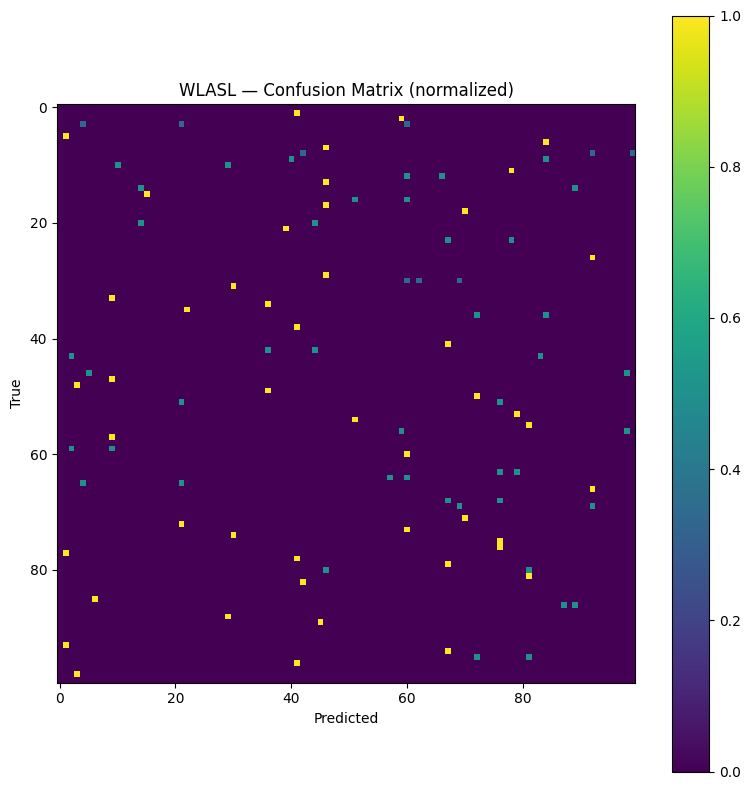

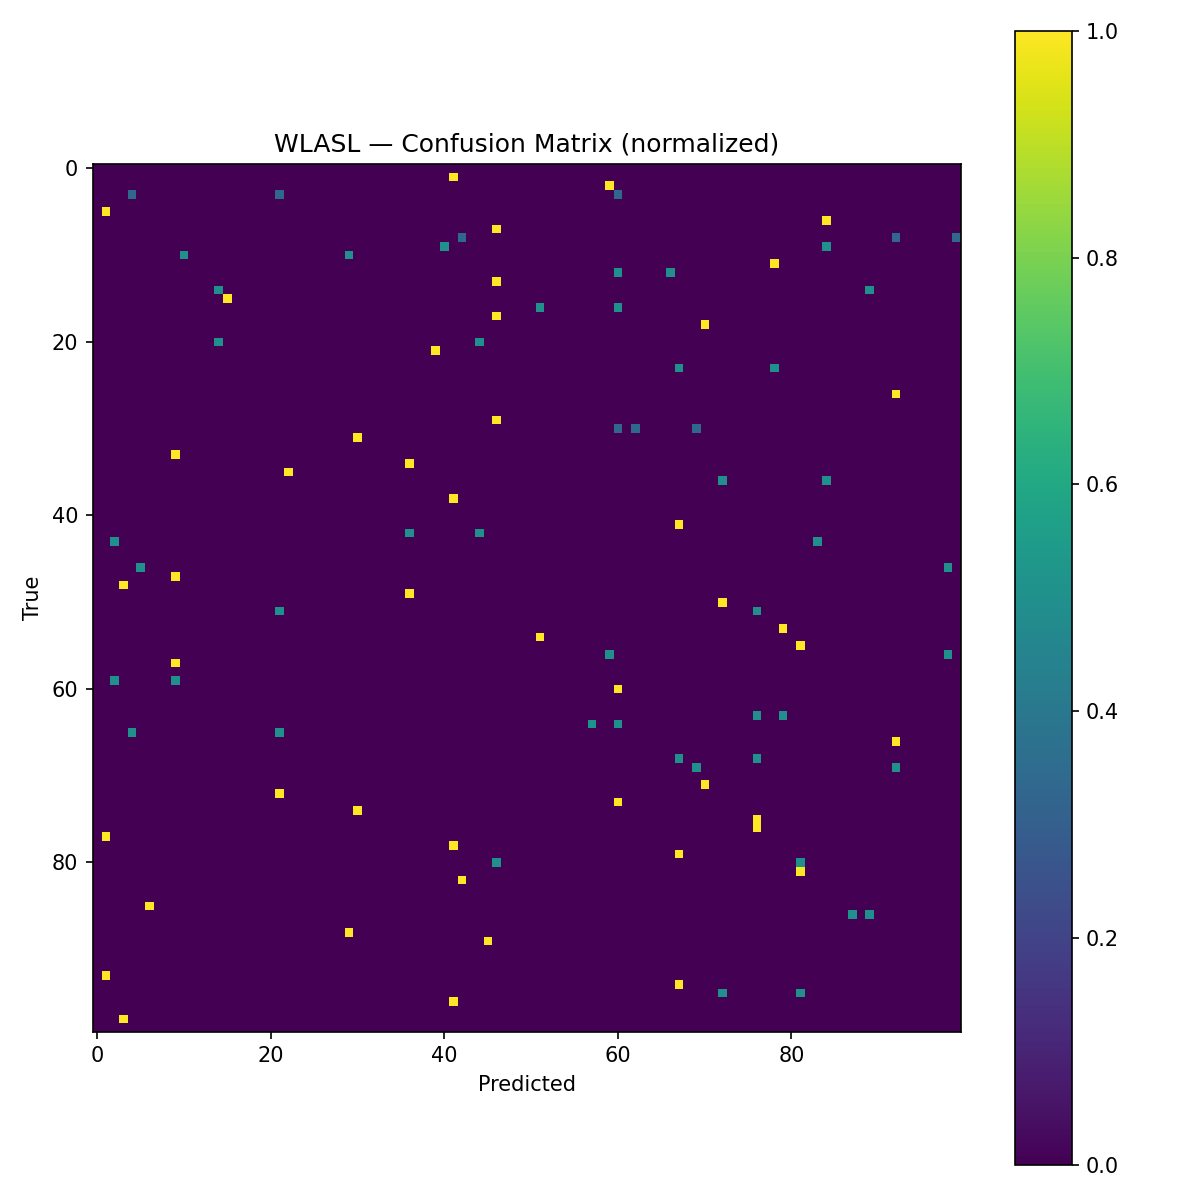

Saved:
- /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs/wlasl100_r3d18_k400_T32_B8_20251109T174731Z.cm_norm.png
- /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs/wlasl100_r3d18_k400_T32_B8_20251109T174731Z.per_class_accuracy.csv


In [17]:
# === Cell F — Confusion Matrix & Per-Class Report (show + save) ===
import torch
from torch.amp import autocast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import display, Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- rebuild model exactly like Cell C/D and load best ---
from torchvision.models.video import r3d_18, R3D_18_Weights
if CONFIG["backbone"] == "r3d18_k400":
    weights = R3D_18_Weights.KINETICS400_V1
    model = r3d_18(weights=weights)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    EXPECTS_BCTHW = True
else:
    class C3DliteGN(torch.nn.Module):
        def __init__(self, num_classes=100, drop=0.5):
            super().__init__()
            def gn(c): return torch.nn.GroupNorm(num_groups=8, num_channels=c)
            def block(cin, cout, pool_t=2):
                return torch.nn.Sequential(
                    torch.nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                    gn(cout), torch.nn.ReLU(inplace=True),
                    torch.nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2))
                )
            self.stem = torch.nn.Sequential(torch.nn.Conv3d(3,32,3,padding=1,bias=False), gn(32), torch.nn.ReLU(inplace=True))
            self.b1 = block(32,  64)
            self.b2 = block(64, 128)
            self.b3 = block(128, 256)
            self.b4 = block(256, 256)
            self.head = torch.nn.Sequential(torch.nn.AdaptiveAvgPool3d(1), torch.nn.Flatten(),
                                            torch.nn.Dropout(CONFIG["dropout"]),
                                            torch.nn.Linear(256, num_classes))
        def forward(self, x):  # [B,T,C,H,W]
            x = x.permute(0,2,1,3,4).contiguous()  # -> [B,C,T,H,W]
            x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
            return self.head(x)
    model = C3DliteGN(num_classes=num_classes, drop=CONFIG["dropout"])
    EXPECTS_BCTHW = False

ckpt = torch.load(CKPT_DIR / "best.pt", map_location=device)
# robust to old _orig_mod prefixes
def _clean_keys(sd):
    out = {}
    for k, v in sd.items():
        for pref in ("module.", "backbone.", "model.", "_orig_mod."):
            if k.startswith(pref):
                k = k[len(pref):]
        out[k] = v
    return out
state = ckpt.get("model", ckpt.get("state_dict", ckpt))
model.load_state_dict(_clean_keys(state), strict=False)
model.to(device).eval()

# --- collect predictions on test ---
y_true, y_pred = [], []
with torch.no_grad(), autocast("cuda", enabled=CONFIG["amp"]):
    for xb, yb, _ in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        if EXPECTS_BCTHW:
            xb = xb.permute(0, 2, 1, 3, 4).contiguous()  # [B,T,C,H,W] -> [B,C,T,H,W]
        logits = model(xb)
        y_true.append(yb.cpu().numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- confusion matrix ---
labels = list(range(num_classes))
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

# --- plot (show inline) + save ---
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title("WLASL — Confusion Matrix (normalized)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()  # <-- SHOW INLINE

cm_img_path = RUNS_DIR / f"{run_tag}.cm_norm.png"
fig.savefig(cm_img_path, dpi=150)

# Also display the saved image so you can verify the file:
display(Image(filename=str(cm_img_path)))

# --- per-class accuracy table (+ gloss names) ---
per_class_acc = (cm.diagonal() / np.maximum(cm.sum(axis=1), 1))
rep = pd.DataFrame({"label": labels, "accuracy": per_class_acc})

_manifest_df = pd.read_csv(MANIFEST)
_label2gloss = _manifest_df.drop_duplicates("label").set_index("label")["gloss"].to_dict()
rep["gloss"] = rep["label"].map(_label2gloss)

rep_csv_path = RUNS_DIR / f"{run_tag}.per_class_accuracy.csv"
rep.sort_values("accuracy", ascending=True).to_csv(rep_csv_path, index=False)

print("Saved:")
print("-", cm_img_path)
print("-", rep_csv_path)
